# Extract satellite data at time and location of WOD data
Crrated by Ivan Lima on Tue Nov 30 2021 14:13:34 -0500

This notebook is used for development and testing. The satellite data extraction is done using the Python script `extract_satellite_data_WOD.py`

In [1]:
%matplotlib inline
import pandas as pd
import xarray as xr
import numpy as np
import datetime, os, glob, warnings
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tnrange, notebook
from ccsm_utils import find_stn, find_stn_idx, find_closest_pt, extract_loc
from cesm_utils import da2ma
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Thu Dec  2 10:26:54 2021


In [2]:
sns.set_theme(context='paper', style='ticks', palette='tab10', rc={'figure.dpi':100, 'figure.figsize':[5, 5], 'axes.grid':True})
pd.options.display.max_columns = 20
warnings.filterwarnings('ignore')

In [3]:
df_in = pd.read_csv('data/CombinedCTD_metadata_bathy_600m_sorted.csv', parse_dates=['Date'], index_col=0)

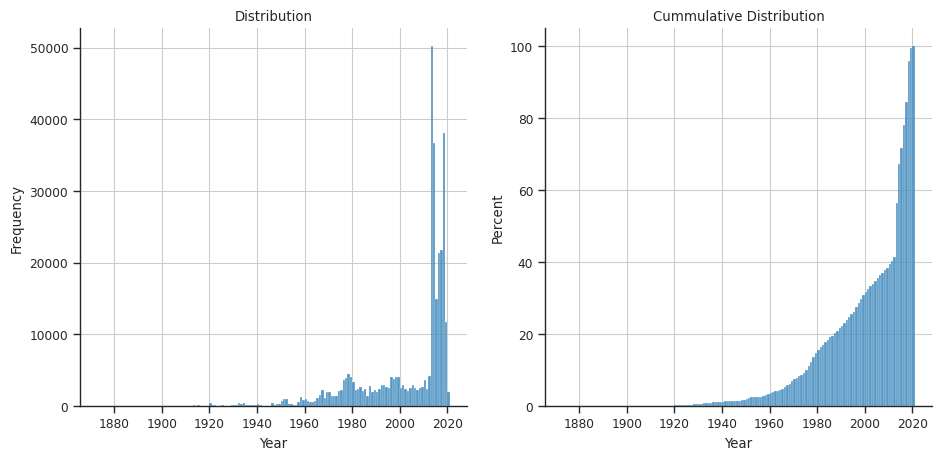

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(11,5))
_ = sns.histplot(data=df_in, x='Year', binwidth=1, stat='frequency', ax=axs[0])
_ = sns.histplot(data=df_in, x='Year', binwidth=1, cumulative=True, stat='percent', ax=axs[1])
_ = axs[0].set_title('Distribution')
_ = axs[1].set_title('Cummulative Distribution')
sns.despine(fig)

In [6]:
for year in df_in.Year.unique():
    df = df_in[df_in.Year==year]
    print('Year {}: {:5d} points'.format(year, len(df)))

Year 1873:     1 points
Year 1912:    37 points
Year 1913:    64 points
Year 1914:    45 points
Year 1915:   121 points
Year 1916:    42 points
Year 1917:     8 points
Year 1918:     1 points
Year 1919:    36 points
Year 1920:   447 points
Year 1921:   181 points
Year 1922:   116 points
Year 1923:     1 points
Year 1924:    26 points
Year 1925:    91 points
Year 1926:    31 points
Year 1927:    50 points
Year 1928:    56 points
Year 1929:   156 points
Year 1930:   182 points
Year 1931:   147 points
Year 1932:   455 points
Year 1933:   327 points
Year 1934:   450 points
Year 1935:   106 points
Year 1936:   180 points
Year 1937:   127 points
Year 1938:   140 points
Year 1939:   149 points
Year 1940:   233 points
Year 1941:   139 points
Year 1942:     6 points
Year 1943:     9 points
Year 1944:    10 points
Year 1945:    44 points
Year 1946:   428 points
Year 1947:   148 points
Year 1948:   279 points
Year 1949:   236 points
Year 1950:   726 points
Year 1951:   992 points
Year 1952:   923

In [6]:
ssh_dir = '/bali/data/ilima/Satellite_Data/AVISO/daily/'
sst_dir = '/bali/data/ilima/Satellite_Data/SST/NOAA_OI/'
# sst_hr_dir = '/bali/data/ilima/Satellite_Data/SST/PO.DAAC/'
# chl_dir = '/bali/data/ilima/Satellite_Data/Ocean_Color/Chl/daily/'
# kd490_dir = '/bali/data/ilima/Satellite_Data/Ocean_Color/KD490/daily/'
sst_hr_dir = '/home/ivan/Data/Postproc/Satellite_Data/PO.DAAC/'
chl_dir = '/home/ivan/Data/Postproc/Satellite_Data/CHL/'
kd490_dir = '/home/ivan/Data/Postproc/Satellite_Data/KD490/'

cols = ['Cast', 'Latitude', 'Longitude', 'Year', 'Month', 'Day', 'Platform_Type',
        'bottom_depth', 'Date', 'SLA', 'SST', 'SST_hires', 'Chl', 'KD490']

# for year in range(2020, df.Year.max()+1):
for year in range(1998, 1999):
    df_obs = df_in[df_in.Year==year]
    print('Year {}: {} points'.format(year, len(df_obs)))

    for i in notebook.tqdm(df_obs.index):
        year, month, day = df_obs.loc[i,'Date'].year, df_obs.loc[i,'Date'].month, df_obs.loc[i,'Date'].day
        doy = df_obs.loc[i,'Date'].day_of_year

        # print('record {:6d}/{}, year={}'.format(i, df_obs.index.max(), df_obs.loc[i,'Year']))

        # extract AVISO SSH data
        ssh_file = glob.glob(ssh_dir + '{}/{:02}/dt_global_allsat_phy_l4_{}{:02}{:02}_????????.nc'.format(year,month,year,month,day))
        if ssh_file:
            with xr.open_dataset(ssh_file[0]) as ds:
                lon_sat, lat_sat = np.meshgrid(ds.longitude, ds.latitude)
                lon_obs, lat_obs = df_obs.loc[i,['Longitude','Latitude']]
                lon_obs = lon_obs + 360.
                for var in ['sla']:
                    df_obs.loc[i,var.upper()] = extract_loc(lon_obs, lat_obs, lon_sat, lat_sat, da2ma(ds[var]))
        else:
            for var in ['sla']:
                df_obs.loc[i,var.upper()] = np.nan

        # extract SST (0.25 x 0.25 degree) data
        sst_file = glob.glob(sst_dir + '{}/{:03d}/{}*AVHRR_OI*.nc'.format(year,doy,year))
        if sst_file:
            with xr.open_dataset(sst_file[0]) as ds:
                lon_sat, lat_sat = np.meshgrid(ds.lon, ds.lat)
                lon_obs, lat_obs = df_obs.loc[i,['Longitude','Latitude']]
                data = da2ma(ds['analysed_sst'].squeeze() - 273.15) # Kelvin -> Celsius
                df_obs.loc[i,'SST'] = extract_loc(lon_obs, lat_obs, lon_sat, lat_sat, data)
        else:
            df_obs.loc[i,'SST'] = np.nan

        # extract high res SST (0.01 x 0.01 degree) data
        # sst_hr_file = sst_hr_dir + '{}/{:03d}/{}{:02}{:02}090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc'.format(year,doy,year,month,day)
        sst_hr_file = sst_hr_dir + 'subset_{}{:02}{:02}090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc'.format(year,month,day)
        if os.path.isfile(sst_hr_file):
            with xr.open_dataset(sst_hr_file) as ds:
                lon_sat, lat_sat = np.meshgrid(ds.lon, ds.lat)
                lon_obs, lat_obs = df_obs.loc[i,['Longitude','Latitude']]
                data = da2ma(ds['analysed_sst'].squeeze() - 273.15) # Kelvin -> Celsius
                df_obs.loc[i,'SST_hires'] = extract_loc(lon_obs, lat_obs, lon_sat, lat_sat, data)
        else:
            df_obs.loc[i,'SST_hires'] = np.nan

        # extract surface Chl (~4.64 Km resolution)
        # chl_file = chl_dir + '{}/{:02}/{}{:02}{:02}_d-ACRI-L4-CHL-MULTI_4KM-GLO-REP.nc'.format(year,month,year,month,day)
        chl_file = chl_dir + 'subset_{}{:02}{:02}_d-ACRI-L4-CHL-MULTI_4KM-GLO-REP.nc'.format(year,month,day)
        if os.path.isfile(chl_file):
            with xr.open_dataset(chl_file) as ds:
                lon_sat, lat_sat = np.meshgrid(ds.lon, ds.lat)
                lon_obs, lat_obs = df_obs.loc[i,['Longitude','Latitude']]
                data = da2ma(ds['CHL'].squeeze())
                df_obs.loc[i,'Chl'] = extract_loc(lon_obs, lat_obs, lon_sat, lat_sat, data)
        else:
            df_obs.loc[i,'Chl'] = np.nan

        # extract surface KD490 (~4.64 Km resolution)
        # kd490_file = kd490_dir + '{}/{:02}/{}{:02}{:02}_d-ACRI-L4-KD490-MULTI_4KM-GLO-REP.nc'.format(year,month,year,month,day)
        kd490_file = kd490_dir + '/subset_{}{:02}{:02}_d-ACRI-L4-KD490-MULTI_4KM-GLO-REP.nc'.format(year,month,day)
        if os.path.isfile(kd490_file):
            with xr.open_dataset(kd490_file) as ds:
                lon_sat, lat_sat = np.meshgrid(ds.lon, ds.lat)
                lon_obs, lat_obs = df_obs.loc[i,['Longitude','Latitude']]
                data = da2ma(ds['KD490'].squeeze())
                df_obs.loc[i,'KD490'] = extract_loc(lon_obs, lat_obs, lon_sat, lat_sat, data)
        else:
            df_obs.loc[i,'KD490'] = np.nan
            
    df_out = df_obs[cols]
    df_out = df_out.fillna('NA')
    outfile = 'data/by_year/test/CombinedCTD_metadata_satellite_{}.csv'.format(year)
    print('writing {}\n'.format(outfile))
    df_out.to_csv(outfile)

Year 1998: 3981 points


  0%|          | 0/3981 [00:00<?, ?it/s]

writing data/by_year/test/CombinedCTD_metadata_satellite_1998.csv

